In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA L4 (UUID: GPU-b06f3350-cffa-9e0a-12db-7813b3212076)


# Packages

In [ ]:
# Necessary for Tensorflow-IO on Google Collab
%pip install tensorflow==2.12
%pip install tensorflow_io==0.32.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 46.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Unins

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 80.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.36.0
    Uninstalling tensorflow-io-gcs-filesystem-0.36.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.36.0
  Attempting uninstall: tensorflow_io
    Found existing installation: tensorflow-io 0.36.0
    Uninstalling tensorflow-io-0.36.0:
      Successfully uninstalled tensorflow-io-0.36.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.12.0 which is incompatible.


In [ ]:
%pip install sklearn==0.0
%pip install nina-helper
%pip install tensorflow_addons
%pip install pyts
# %pip install tensorflow_io==0.36.0 # Check Compatability https://pypi.org/project/tensorflow-io/
# %pip install tensorflow==2.14
# %pip install tensorflow_io==0.35.0
# %pip install tensorflow_io

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1303 sha256=2910945b7cff6ec76c5ca5c5745c973dce60f3e5ce083827182b122673903fa5
  Stored in directory: /root/.cache/pip/wheels/9b/13/01/6f3a7fd641f90e1f6c8c7cded057f3394f451f340371c68f3d
Successfully built sklearn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from nina_helper import *
import numpy as np
import os
import pandas as pd
import random
import gc
import h5py
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score, classification_report
from scipy import signal

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, initializers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D,Conv2D,Conv3D, Add, MaxPool1D, MaxPooling2D,MaxPool3D,GlobalAveragePooling3D
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model, Sequence
#from tensorflow_addons.layers import WeightNormalization

import tensorflow.keras.backend as K

import tensorflow_io as tfio

In [ ]:
print(tf.__version__)

2.15.0


# Data Preprocessing Functions

In [ ]:
def condense_emg_data(emg_data, move_labels, rep_labels, which_moves, which_reps, fs, t):
  # Identify where labels change
  indexes = np.where((move_labels[1:] != move_labels[:-1]) |
                     (rep_labels[1:] != rep_labels[:-1]))[0] + 1
  indexes = np.concatenate((np.array([0]), indexes))
  select_indexes = []

  # Only keep index which are what you are looking for in terms of moves and reps
  for index in indexes:
    if(move_labels[index] in which_moves and rep_labels[index] in which_reps):
      select_indexes.append(index.tolist())

  # From each valid starting index which representes the start of a repetition,
  # select the specified number of samples corresponding to the desired length of time
  condensed_emg_data = np.array([emg_data[idx:idx+int(t * fs)] for idx in select_indexes])
  condensed_move_labels = np.array([move_labels[idx:idx+int(t * fs)] for idx in select_indexes])
  condensed_rep_labels = np.array([rep_labels[idx:idx+int(t * fs)] for idx in select_indexes])
  return condensed_emg_data, condensed_move_labels, condensed_rep_labels

In [ ]:
def filter_data(data, f, butterworth_order=4, btype='lowpass', fs=2000):
    # Input has shape (sample, interval length, num_sensors_channels_per_grid, num_grids)
    emg_data = data

    nyquist = fs / 2
    if isinstance(f, int):
        fc = f / nyquist
    else:
        fc = [f_val / nyquist for f_val in f]

    b, a = signal.butter(butterworth_order, fc, btype=btype)

    filtered_data = np.empty_like(emg_data)

    for sample in range(emg_data.shape[0]):
        for sensor_channel in range(emg_data.shape[2]):
            for grid in range(emg_data.shape[3]):
                channel_data = emg_data[sample, :, sensor_channel, grid]
                filtered_data[sample, :, sensor_channel, grid] = signal.filtfilt(b, a, channel_data)

    return filtered_data


In [ ]:
def mu_law_normalisation(data):
    mu = 255
    mu_data_list = []

    for channel in range(data.shape[1]):
        mu_data_list.append(np.sin(data[:, channel]) * np.log(1 + mu * np.abs(data[:, channel])) / np.log(1 + mu))

    mu_data = np.squeeze(np.dstack(mu_data_list))

    return mu_data


In [ ]:
def get_patches(processed_data, kernel_size, stride, num_channels):
  # Define patch size and stride

  ksize_height, ksize_width = kernel_size
  stride_height, stride_width = stride
  ksizes = [ 1, ksize_height, ksize_width, 1]
  strides = [ 1, stride_height, stride_width, 1]

  # Reshape input tensor to remove window length dimension
  #data_reshaped = tf.reshape(data, [-1, data.shape[-3], data.shape[-2], num_channels])

  # Extract patches
  patches = tf.image.extract_patches(processed_data, ksizes, strides, [1, 1, 1, 1], padding='VALID')
  # Reshape patches to shape (num_patches, ksize_height, ksize_width, channels)
  num_patches = patches.shape[1] * patches.shape[2]
  patches_reshaped = tf.reshape(patches, [-1, num_patches, ksize_height, ksize_width, num_channels])
  # Reshape patches to original shape (batch_dimension, window_length, kernel_height, kernel_width, channels)
  temp_list = []
  for patch_num in range(patches_reshaped.shape[1]):
    temp_list.append(patches_reshaped[:,patch_num,:,:,:])

  all_patches = np.vstack(temp_list)
  # Print shape of final patches tensor
  print("Dataset multiplier:{} \n".format(num_patches))

  return all_patches, num_patches

In [ ]:
def get_windows(which_reps, window_len, window_inc, emg, movements, repetitons, which_moves=None, dtype=np.float32):
    """Get set of windows based on repetition and movement criteria and associated label + repetition data.
    Args:
        which_reps (array): Which repetitions to return
        window_len (int): Desired window length
        window_inc (int): Desired window increment
        emg (array): EMG data (should be normalise beforehand)
        movements (array): Movement labels
        repetitons (array): Repetition labels
        which_moves (array, optional): Which movements to return - if None use all
        dtype (TYPE, optional): What precision to use for EMG data
    Returns:
        X_data (array): Windowed EMG data
        Y_data (array): Movement label for each window
        R_data (array): Repetition label for each window
    """
    nb_obs = emg.shape[0]
    nb_channels = emg.shape[1]

    # All possible window end locations given an increment size
    possible_targets = np.array(range(window_len - 1, nb_obs, window_inc))

    targets = nina_helper.get_idxs(repetitons[possible_targets], which_reps)

    # Re-adjust back to original range (for indexinging into rep/move)
    targets = (window_len - 1) + targets * window_inc

    # Keep only selected movement(s)
    if which_moves is not None:
        move_targets = nina_helper.get_idxs(movements[targets], which_moves)
        targets = targets[move_targets]

    X_data = np.zeros([targets.shape[0], window_len, nb_channels],
                      dtype=dtype)
    Y_data = np.zeros([targets.shape[0], ], dtype=np.int8)
    R_data = np.zeros([targets.shape[0], ], dtype=np.int8)

    valid_inds = []
    for i, win_end in enumerate(targets):
        win_start = win_end - (window_len - 1)
        if movements[win_start] == movements[win_end]:
            X_data[i, ...] = emg[win_start:win_end + 1, :]  # Include end
            Y_data[i] = movements[win_end]
            R_data[i] = repetitons[win_end]
            valid_inds.append(i)

    return X_data[np.array(valid_inds)], Y_data[np.array(valid_inds)], R_data[np.array(valid_inds)]

In [ ]:
def get_categorical(y):
    return pd.get_dummies(pd.Series(y)).values

In [ ]:
def load_HD_sEMG_data(subject, normalization="z-score", electrode_shift=False):

    file_path = '/my/path/to/raw/data/HD_sEMG_65/s'+str(subject)+'.mat'

    data = h5py.File(file_path, 'r')

    force_data = np.swapaxes(np.array(data['force']), 0, 1)
    length = len(force_data)
    labels = np.swapaxes(np.array(data['adjusted_label']), 0, 1)
    rep_labels = np.swapaxes(np.array(data['adjusted_repetition']), 0, 1)
    rep_labels = rep_labels.reshape(length,)
    move_labels = np.swapaxes(np.array(data['adjusted_class']), 0, 1)
    move_labels = move_labels.reshape(length,)
    extensors_emg = np.swapaxes(np.array(data['emg_extensors']), 0, 2)
    extensors_emg = np.reshape(extensors_emg, (-1, 64))
    flexors_emg = np.swapaxes(np.array(data['emg_flexors']), 0, 2)
    flexors_emg = np.reshape(flexors_emg, (-1, 64))
    emg_data = np.dstack((extensors_emg, flexors_emg))

    del extensors_emg
    del flexors_emg
    gc.collect()

    #######################################
    which_reps = np.arange(1, 5+1)
    which_moves = np.arange(1, 65+1)

    fs = 2048
    t = 1.171875

    emg_data, move_labels, rep_labels = condense_emg_data(emg_data, move_labels, rep_labels, which_moves, which_reps, fs, t)
    move_labels = move_labels.reshape(-1)
    rep_labels = rep_labels.reshape(-1)

    #######################################
    train_reps = [1, 3, 4]
    test_reps = [2, 5]

    if normalization == "z-score":
      # Filter
      emg_data = filter_data(data=emg_data, f=(10,500), butterworth_order=4, btype='bandpass', fs=fs)

      # Z-Score Normalize
      emg_data = normalise_emg(emg_data.reshape(emg_data.shape[0]*emg_data.shape[1], -1), rep_labels, train_reps, move_labels, which_moves=which_moves)

      # Rectify
      emg_data = np.abs(emg_data)

    elif normalization == "mu-law":
      # Filter
      emg_data = filter_data(data=emg_data, f=1, butterworth_order=2, btype='lowpass', fs=fs)

      # Rectify
      emg_data = abs(emg_data)

      print(emg_data.shape)
      # Mu-Law Normalization
      emg_data = mu_law_normalisation(emg_data.reshape(emg_data.shape[0]*emg_data.shape[1], -1))

    print("emg_data.shape, rep_labels.shape, move_labels.shape")
    print(emg_data.shape, rep_labels.shape, move_labels.shape)
    #######################################
    # Patching and Windowing
    window_len = 400
    window_inc = 40

    if electrode_shift:
      emg_data = emg_data.reshape(-1, 64, 2)
      emg_data = emg_data.reshape(emg_data.shape[0], 8, 8, 2)

      move_labels = move_labels.reshape(-1)
      rep_labels = rep_labels.reshape(-1)

      emg_data = tf.convert_to_tensor(emg_data)

      kernel_size = (6, 6)
      stride = (1, 1)
      num_channels = 2

      emg_aug, num_patches = get_patches(emg_data, kernel_size, stride, num_channels)
      move_labels_aug = np.hstack([move_labels]*num_patches)
      rep_labels_aug = np.hstack([rep_labels]*num_patches)
      print("emg_aug: ", emg_aug.shape)

      emg_aug = tf.reshape(emg_aug, [emg_aug.shape[0], -1, 2])
      emg_aug = tf.reshape(emg_aug, [emg_aug.shape[0], -1])
      x_all, y_all, r_all = get_windows(which_reps, window_len, window_inc, emg_aug, move_labels_aug, rep_labels_aug, which_moves)
      x_all = x_all.reshape(x_all.shape[0], x_all.shape[1], -1, 2)
      x_all = x_all.reshape(x_all.shape[0], x_all.shape[1], kernel_size[0], kernel_size[1], 2)

    else:
      x_all, y_all, r_all = get_windows(which_reps, window_len, window_inc, emg_data, move_labels, rep_labels, which_moves)

      x_all = x_all.reshape(x_all.shape[0], x_all.shape[1], -1, 2)
      x_all = x_all.reshape(x_all.shape[0], x_all.shape[1], 8, 8, 2)
    #######################################

    train_idx = get_idxs(r_all, train_reps)
    X_train = x_all[train_idx, :, :, :]
    y_train = y_all[train_idx]

    test_idx = get_idxs(r_all, test_reps)
    X_test = x_all[test_idx, :, :, :]
    y_test = y_all[test_idx]

    y_train = get_categorical(y_train)
    y_test = get_categorical(y_test)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')

    print("X_train.shape, X_test.shape, y_train.shape, y_test.shape:")
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    return X_train, X_test, y_train, y_test

In [ ]:
subject = 1
X_train, X_test, y_train, y_test = load_HD_sEMG_data(subject, normalization="z-score", electrode_shift=False)

emg_data.shape, rep_labels.shape, move_labels.shape
(792000, 128) (792000,) (792000,)
X_train.shape, X_test.shape, y_train.shape, y_test.shape:
(11286, 400, 8, 8, 2) (7920, 400, 8, 8, 2) (11286, 65) (7920, 65)


In [ ]:
def save_data_as_h5(data, labels, subject, split_name="train"):
  # Specify the file name for the HDF5 file
  hdf5_file_name = f"{split_name}_dataset_s{subject}.h5"

  # Create the HDF5 file
  with h5py.File(hdf5_file_name, "w") as hf:
      # Create datasets in the HDF5 file for each array
      hf.create_dataset("data", data=data)
      hf.create_dataset("labels", data=labels)

In [ ]:
# Save Numpy as h5 files in specified directory
# os.chdir('/content/')
# save_data_as_h5(X_train, y_train, subject, split_name="train")
# save_data_as_h5(X_test, y_test, subject, split_name="test")

# Model Training Function

In [ ]:
def train_model(model, X_train, y_train, X_test, y_test, save_to, batch_size= 32, epochs = 2):

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
        mc = ModelCheckpoint(save_to + '_best_model.h5',
             monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

        history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs,  shuffle=True,
                              verbose=1, validation_data=(X_test,y_test), callbacks=[es,mc])

        saved_model = load_model(save_to + '_best_model.h5', custom_objects={'margin_loss': margin_loss})

        # evaluate the model
        _, train_acc = saved_model.evaluate(X_train, y_train, verbose=1)
        _, test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
        print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

        return history,saved_model

In [ ]:
def train_model_data_gen(model, train_data_generator, test_data_generator, save_to, epochs=2):

    es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=30)
    mc = ModelCheckpoint(save_to + '_best_model.h5',
                         monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

    lr_scheduler = ReduceLROnPlateau(monitor='val_categorical_accuracy', mode='max', factor=0.9, patience=10, verbose=1)

	                #batch_size=batch_size,
    history = model.fit(train_data_generator,
                        validation_data=test_data_generator,
                        epochs=epochs,
                        callbacks=[es, mc, lr_scheduler],
                        verbose=1)

    saved_model = load_model(save_to + '_best_model.h5', custom_objects={'margin_loss': margin_loss})

    return history, saved_model


In [ ]:
def eval_model_data_gen(model, train_data_generator, test_data_generator, save_path, save_name):
  # evaluate the model
  _, train_acc = model.evaluate(train_data_generator, verbose=1)
  _, test_acc = model.evaluate(test_data_generator, verbose=1)
  print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

  np.save(os.path.join(save_path,"test_acc_{}".format(save_name)), test_acc)

  return

In [ ]:
def set_seed(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # For TensorFlow 2.3 and above
    # However, deterministic ops might not be supported for all operations
    # and can have performance implications.
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Data Loading

In [ ]:
#####################################
# Choose subjects and desired percentage of reps
subjects = [1,2,3,4,5,6,
            7,8,9,10,11,12,
            13,14,15,16,17,18,
            19,20]

#subject = subjects[int(os.getenv("SLURM_ARRAY_TASK_ID"))]
subject = 1
print('selected_subject: {}'.format(subject))
#####################################


selected_subject: 1


In [ ]:
batch_size = 32
num_gpus = max(1, len(tf.config.list_physical_devices('GPU')))
global_batch_size = int(batch_size * num_gpus)

train_file_paths = [
    f'/content/drive/MyDrive/MERIIT Smart Wearable Devices/Software AI Team/Electrode_Shift/HD_sEMG_DATA/z_score/train_dataset_s{subject}.h5',
    # Add paths to other train datasets here
]

test_file_paths = [
    f'/content/drive/MyDrive/MERIIT Smart Wearable Devices/Software AI Team/Electrode_Shift/HD_sEMG_DATA/z_score/test_dataset_s{subject}.h5',
    # Add paths to other test datasets here
]

def load_and_preprocess_data(file_path):
    # Load data and labels separately with the correct spec
    data = tfio.IODataset.from_hdf5(
        file_path,
        dataset=["/data"],
        spec=tf.TensorSpec(shape=(None, 400,6,6,2), dtype=tf.float32),
        num_parallel_reads=tf.data.AUTOTUNE,
    )
    labels = tfio.IODataset.from_hdf5(
        file_path,
        dataset=["/labels"],
        spec=tf.TensorSpec(shape=(None, 65), dtype=tf.int32),
        num_parallel_reads=tf.data.AUTOTUNE,
    )

    # Combine data and labels into a single dataset
    dataset = tf.data.Dataset.zip((data, labels))

    return dataset

train_dataset = load_and_preprocess_data(train_file_paths)
test_dataset = load_and_preprocess_data(test_file_paths)

train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(global_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(global_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Check Dataset's data type and shape
single_batch = train_dataset.take(1)
images, labels = tf.data.Dataset.get_single_element(single_batch)
single_image, single_label = images[0], labels[0]

print("Type of a single image:", type(single_image))
print("Shape of a single image:", single_image.shape)

print("Type of a single label:", type(single_label))
print("Shape of a single label:", single_label.shape)

# Model Training

## 3D CNN

In [ ]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [ ]:
def CNN_3D(input_shape, n_class):
    """
      "Deep Augmentation for Electrode Shift Compensation in
      Transient High-density sEMG: Towards Application in Neurorobotics"
    """

    x = layers.Input(shape=input_shape)

    conv1 = tf.keras.layers.Conv3D(filters=8,kernel_size=(100,2,2),
                                   kernel_initializer= initializers.glorot_uniform(),activation='relu')(x)

    conv2 = tf.keras.layers.Conv3D(filters=16,kernel_size=(100,2,2),
                                   kernel_initializer= initializers.glorot_uniform(),activation='relu')(conv1)

    conv3 = tf.keras.layers.Conv3D(filters=32,kernel_size=(100,2,2),
                                   kernel_initializer= initializers.glorot_uniform(),activation='relu')(conv2)

    conv4 = tf.keras.layers.Conv3D(filters=64,kernel_size=(100,2,2),
                                   kernel_initializer= initializers.glorot_uniform(),activation='relu')(conv3)

    conv5 = tf.keras.layers.Conv3D(filters=128,kernel_size=(4,2,2),
                                   kernel_initializer= initializers.glorot_uniform(),activation='relu')(conv4)


    flat = Flatten()(conv5)
    Dense1 = Dense(128,activation='tanh')(flat)
    drop1 = Dropout(0.2)(Dense1)
    Dense2 = Dense(96,activation='tanh')(drop1)
    drop2 = Dropout(0.2)(Dense2)

    Dense3 = Dense(n_class,activation='softmax')(drop2)

    model = tf.keras.Model(inputs=x,
                           outputs=Dense3,
                           name="3D_CNN")

    return model

### Loaded H5 Data Generator for Electrode-Shift Data
* Shape (None,400,6,6,2)
* Currently only working with the following package versions in Google Colab
  * tensorflow==2.12
  * tensorflow_io==0.32.0




In [ ]:
strategy = tf.distribute.MirroredStrategy()

initial_learning_rate = 1e-4

# Dummy Input Variables for building Models
dummy_X = np.random.randn(*(32, 400, 6, 6, 2))
dummy_y = np.random.randn(*(32, 65))

with strategy.scope(): # creating the model in the TPUStrategy scope places the model on the TPU
    model = CNN_3D(dummy_X[0].shape, dummy_y.shape[1])
    #model = CapsNet_3D(X_train[0].shape, y_train.shape[1], num_routing=3)

    opt_adam = keras.optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=opt_adam,
                    loss=[margin_loss, 'mse'],
                    #loss='categorical_crossentropy',
                    loss_weights=[1., 0.0005],
                    metrics='categorical_accuracy')
model.summary()

Model: "3D_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 400, 6, 6, 2)]    0         
                                                                 
 conv3d_10 (Conv3D)          (None, 301, 5, 5, 8)      6408      
                                                                 
 conv3d_11 (Conv3D)          (None, 202, 4, 4, 16)     51216     
                                                                 
 conv3d_12 (Conv3D)          (None, 103, 3, 3, 32)     204832    
                                                                 
 conv3d_13 (Conv3D)          (None, 4, 2, 2, 64)       819264    
                                                                 
 conv3d_14 (Conv3D)          (None, 1, 1, 1, 128)      131200    
                                                                 
 flatten_2 (Flatten)         (None, 128)               0    

In [ ]:
#set_seed(42)
# Hyper-parameters
epochs = 2

histories, saved_model = train_model_data_gen(model, train_dataset, test_dataset,
                                              save_to = 'Electrode_Shift_subject{}_{}epochs'.format(subject, epochs),
                                              epochs = epochs)

Epoch 1/2
   3341/Unknown - 2030s 605ms/step - loss: 0.6479 - categorical_accuracy: 0.2277
Epoch 1: val_categorical_accuracy improved from -inf to 0.26794, saving model to Electrode_Shift_subject1_2epochs_best_model.h5
3341/3341 [==============================] - 2371s 707ms/step - loss: 0.6479 - categorical_accuracy: 0.2277 - val_loss: 0.6094 - val_categorical_accuracy: 0.2679 - lr: 1.0000e-04
Epoch 2/2
3341/3341 [==============================] - ETA: 0s - loss: 0.4624 - categorical_accuracy: 0.4611
Epoch 2: val_categorical_accuracy improved from 0.26794 to 0.40450, saving model to Electrode_Shift_subject1_2epochs_best_model.h5
3341/3341 [==============================] - 2310s 691ms/step - loss: 0.4624 - categorical_accuracy: 0.4611 - val_loss: 0.4904 - val_categorical_accuracy: 0.4045 - lr: 1.0000e-04


In [ ]:
test_acc_save_path = '/content/'
save_name = "subject{}_{}".format(subject, model.name)

eval_model_data_gen(model, train_dataset, test_dataset, test_acc_save_path, save_name)

2228/2228 [==============================] - 330s 148ms/step - loss: 0.4904 - categorical_accuracy: 0.4045
Train: 0.432, Test: 0.405


### Numpy

In [ ]:
subject = 1
X_train, X_test, y_train, y_test = load_HD_sEMG_data(subject, normalization="z-score")

X_train.shape, X_test.shape, y_train.shape, y_test.shape:
(11286, 400, 8, 8, 2) (7920, 400, 8, 8, 2) (11286, 65) (7920, 65)


In [ ]:
set_seed(42)

strategy = tf.distribute.MirroredStrategy()

initial_learning_rate = 1e-4

# Dummy Input Variables for building Models
dummy_X = np.random.randn(*(32, 400, 8, 8, 2))
dummy_y = np.random.randn(*(32, 65))

with strategy.scope(): # creating the model in the TPUStrategy scope places the model on the TPU
    model = CNN_3D(dummy_X[0].shape, dummy_y.shape[1])
    #model = CapsNet_3D(X_train[0].shape, y_train.shape[1], num_routing=3)

    opt_adam = keras.optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=opt_adam,
                    loss=[margin_loss, 'mse'],
                    #loss='categorical_crossentropy',
                    loss_weights=[1., 0.0005],
                    metrics='categorical_accuracy')
model.summary()


Model: "3D_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 400, 8, 8, 2)]    0         
                                                                 
 conv3d_25 (Conv3D)          (None, 301, 7, 7, 8)      6408      
                                                                 
 conv3d_26 (Conv3D)          (None, 202, 6, 6, 16)     51216     
                                                                 
 conv3d_27 (Conv3D)          (None, 103, 5, 5, 32)     204832    
                                                                 
 conv3d_28 (Conv3D)          (None, 4, 4, 4, 64)       819264    
                                                                 
 conv3d_29 (Conv3D)          (None, 1, 3, 3, 128)      131200    
                                                                 
 flatten_5 (Flatten)         (None, 1152)              0    

In [ ]:
epochs = 50
batch_size = 32

histories, model = train_model(model, X_train, y_train, X_test, y_test,
                               save_to = f'{model.name}',
                               batch_size=batch_size, epochs = epochs)

Epoch 1/50
353/353 [==============================] - ETA: 0s - loss: 0.7237 - categorical_accuracy: 0.1415
Epoch 1: val_categorical_accuracy improved from -inf to 0.25442, saving model to 3D_CNN_best_model.h5
353/353 [==============================] - 19s 46ms/step - loss: 0.7237 - categorical_accuracy: 0.1415 - val_loss: 0.6498 - val_categorical_accuracy: 0.2544
Epoch 2/50
  3/353 [..............................] - ETA: 11s - loss: 0.6727 - categorical_accuracy: 0.2188

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


353/353 [==============================] - ETA: 0s - loss: 0.6191 - categorical_accuracy: 0.2981
Epoch 2: val_categorical_accuracy improved from 0.25442 to 0.35505, saving model to 3D_CNN_best_model.h5
353/353 [==============================] - 13s 38ms/step - loss: 0.6191 - categorical_accuracy: 0.2981 - val_loss: 0.5644 - val_categorical_accuracy: 0.3551
Epoch 3/50
353/353 [==============================] - ETA: 0s - loss: 0.5341 - categorical_accuracy: 0.4104
Epoch 3: val_categorical_accuracy improved from 0.35505 to 0.44697, saving model to 3D_CNN_best_model.h5
353/353 [==============================] - 13s 38ms/step - loss: 0.5341 - categorical_accuracy: 0.4104 - val_loss: 0.4859 - val_categorical_accuracy: 0.4470
Epoch 4/50
353/353 [==============================] - ETA: 0s - loss: 0.4404 - categorical_accuracy: 0.5335
Epoch 4: val_categorical_accuracy improved from 0.44697 to 0.56263, saving model to 3D_CNN_best_model.h5
353/353 [==============================] - 13s 38ms/step -

# Reports + Confusion Matrix

In [ ]:
def Statistics(data, y_test):
  # Classification Report
  report = classification_report(data['actual labels'],data['predicted labels'],output_dict=True)
  report = pd.DataFrame(report).T
  # Confusion matrix
  #print("Confusion matrix is shown below")
  c_matrix=confusion_matrix(data['actual labels'],data['predicted labels'])
  FP = c_matrix.sum(axis=0) - np.diag(c_matrix)
  FN = c_matrix.sum(axis=1) - np.diag(c_matrix)
  TP = np.diag(c_matrix)
  TN = c_matrix.sum() - (FP + FN + TP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)
  # Sensitivity or positive recall
  TPR = TP/(TP+FN)
  # Specificity or true negative rate or negative recall
  TNR = TN/(TN+FP)
  accuracy = accuracy_score(data['actual labels'],data['predicted labels'])
  TNR = np.append(TNR,[accuracy, TNR.mean(), ((TNR * report['support'][:y_test.shape[1]]).sum())/(report['support'][:y_test.shape[1]].sum())])
  report['specificity'] = TNR # adding new column specificity
  plt.figure(figsize=(40,20))
  norm_c_matrix = c_matrix.astype('float') / c_matrix.sum(axis=1)[:, np.newaxis]
  sns.heatmap(norm_c_matrix, annot=True,cmap='Blues', fmt='.2f')
  #sns.heatmap(c_matrix, annot=True,cmap='Blues', fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  plt.savefig("confusion_mat.jpg")
  balanced_acc = balanced_accuracy_score(data['actual labels'],data['predicted labels'])
  print("Balanced_accuracy:{}".format(balanced_acc))
  #print("Classification Report is shown below")
  return report, c_matrix, norm_c_matrix, balanced_acc

# summarize history for accuracy
def plot_accuracy(histories):
  plt.plot(histories.history['categorical_accuracy'])
  plt.plot(histories.history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# summarize history for loss
def plot_loss(histories):
  plt.clf
  plt.plot(histories.history['loss'])
  plt.plot(histories.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()



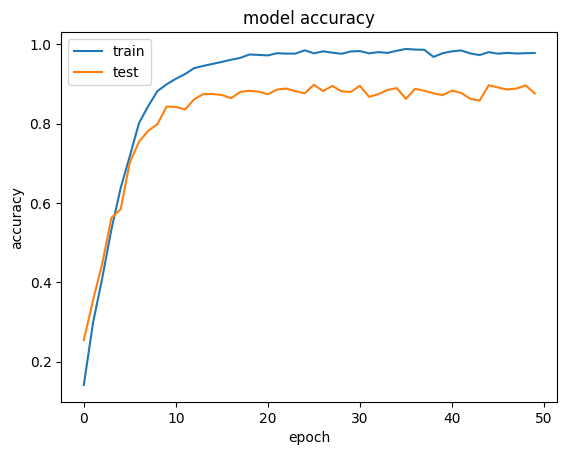

In [ ]:
plot_accuracy(histories)

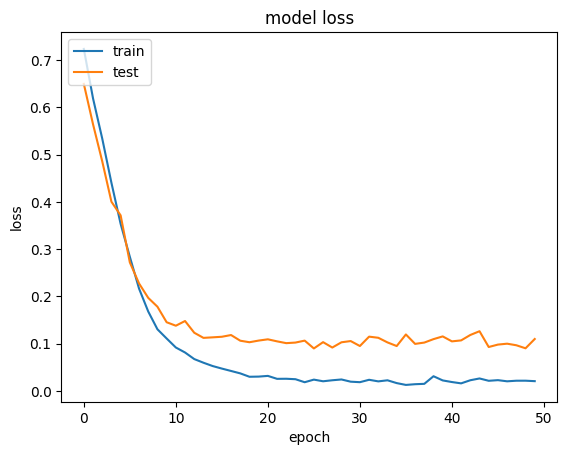

In [ ]:
plot_loss(histories)

248/248 [==============================] - 2s 6ms/step
y_test, y_pred: (7920,) (7920,)
Balanced_accuracy:0.8962820512820514


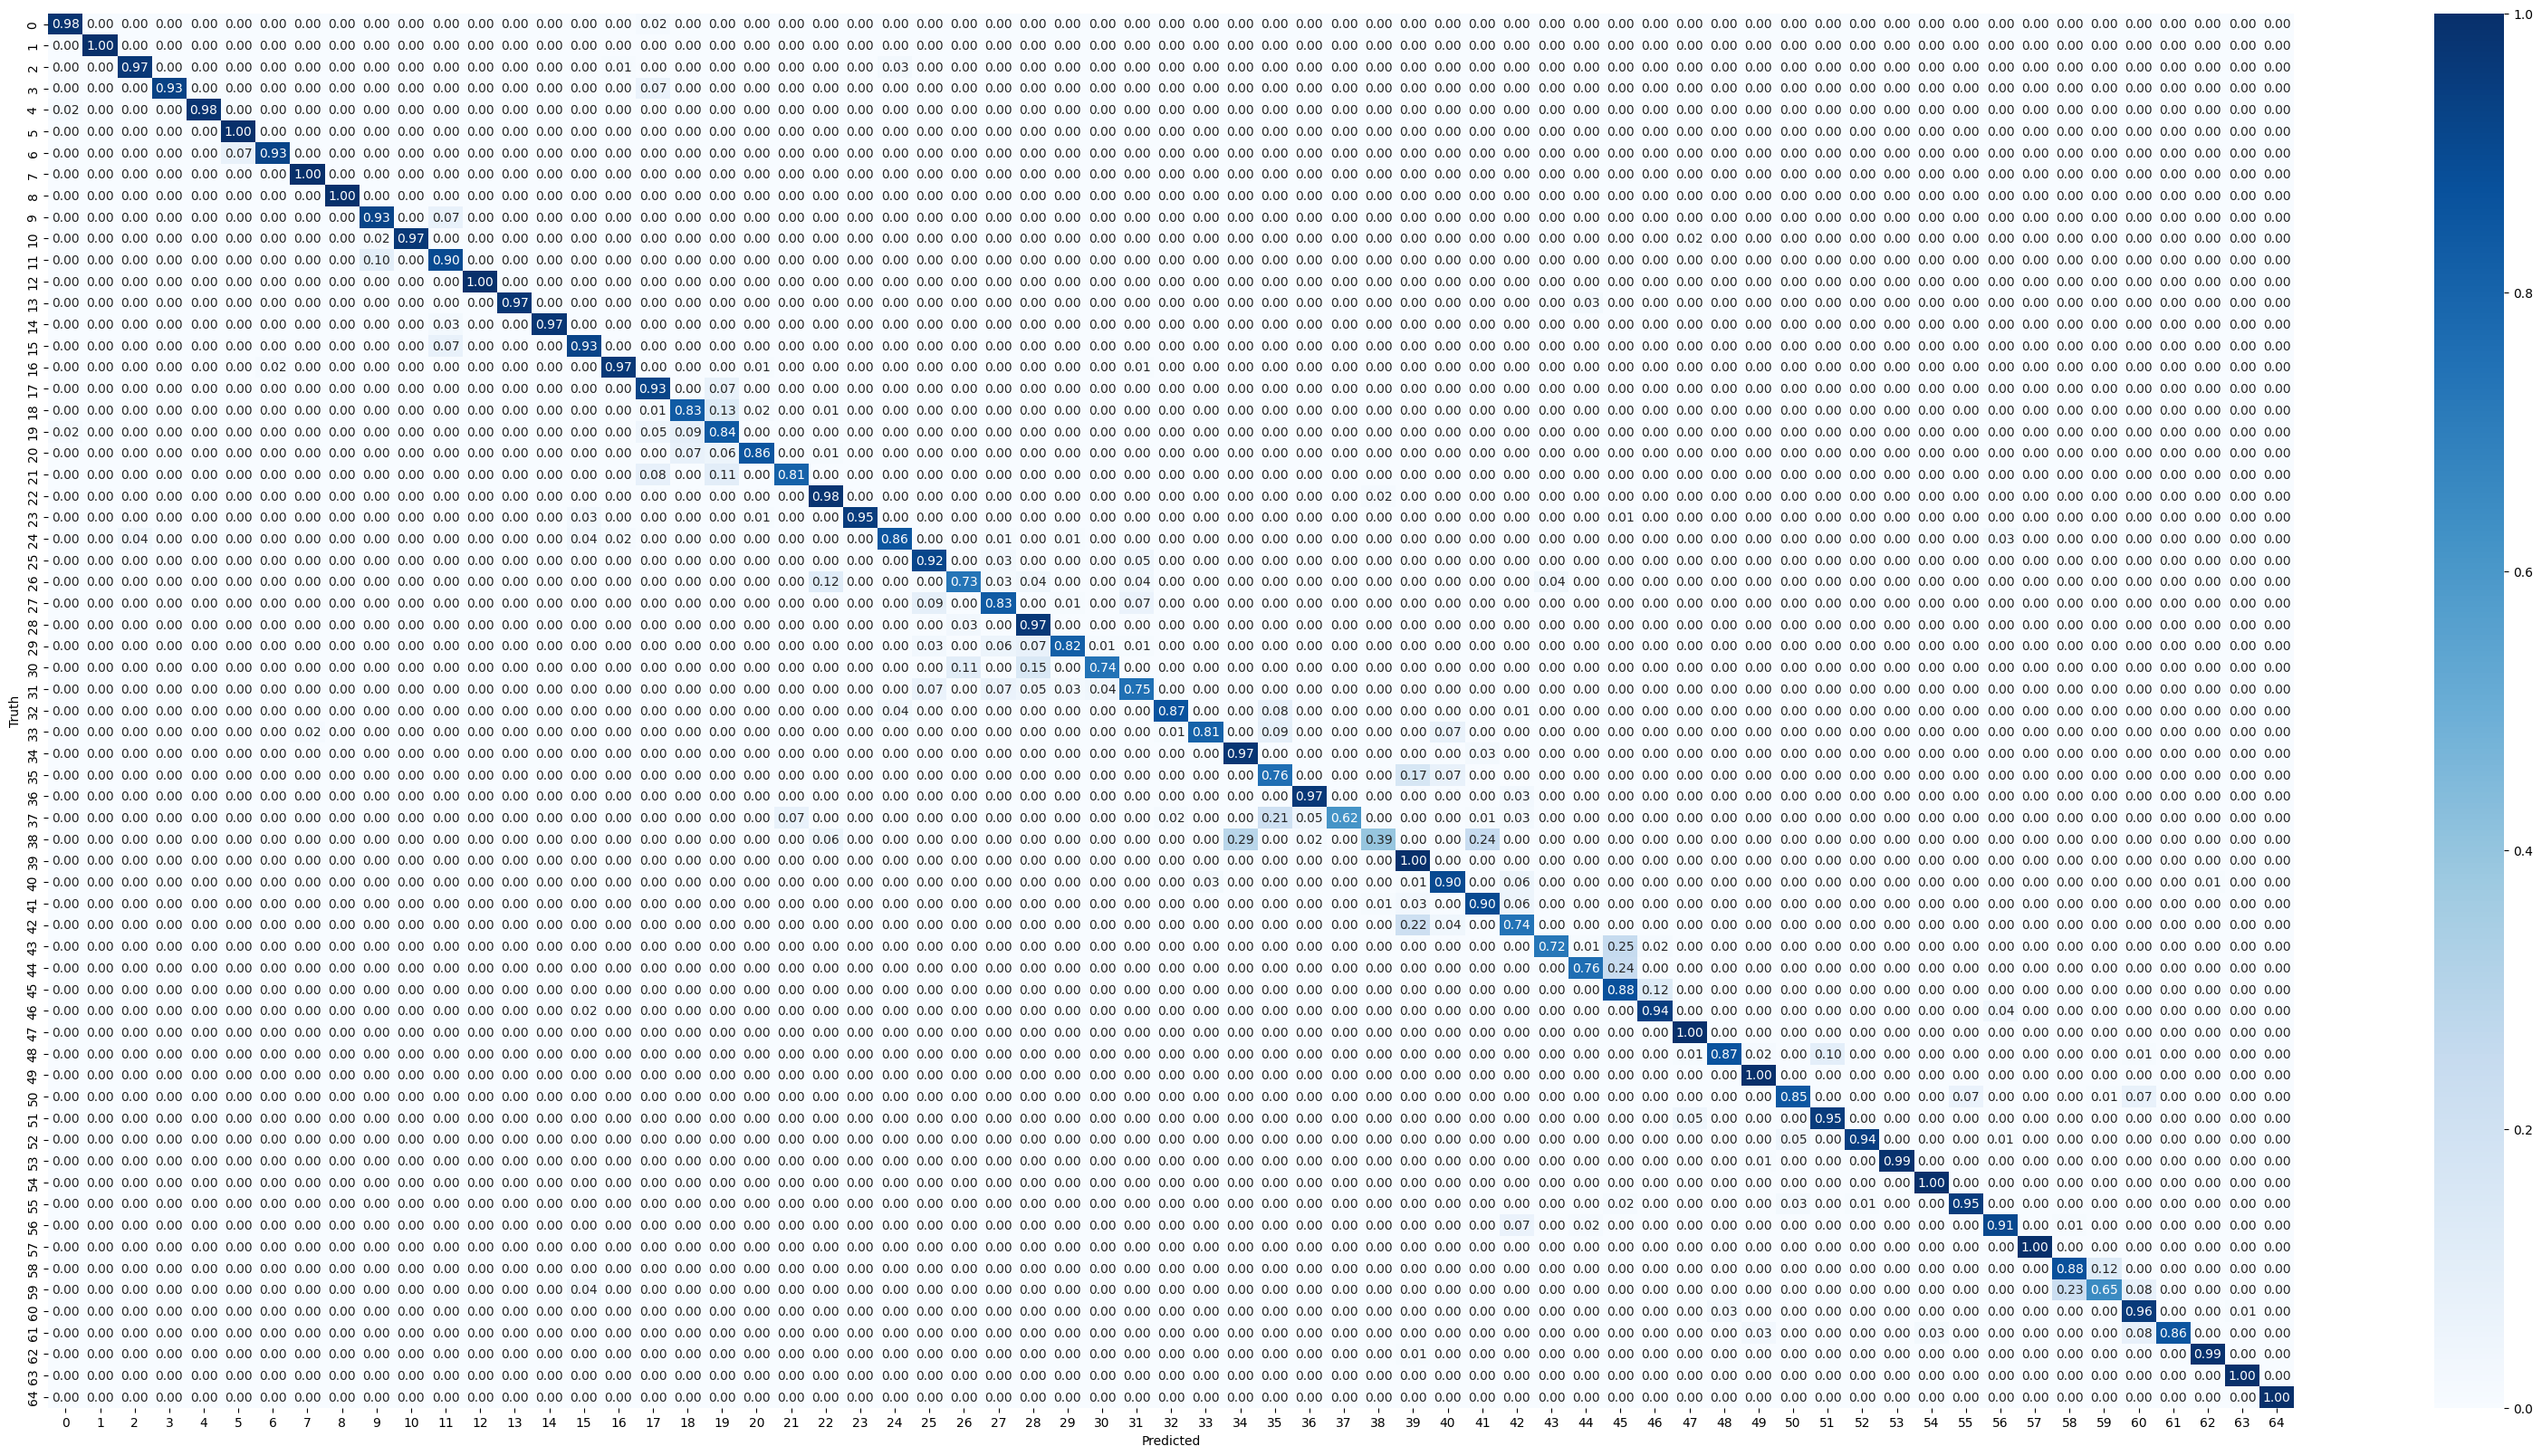

In [ ]:
# Reports + Confusion Matrix
#
# If loading model from another directory, set model path
# model_path = "model/directory/"
# model = load_model(os.path.normpath(model_path + model_name))

save_to = f'{model.name}'
model_name = save_to + '_best_model.h5'
model =  load_model(model_name, custom_objects={'margin_loss': margin_loss})

#y_test = np.array(y_test)
y_tested = np.argmax(y_test,axis=1)
y_pred = model.predict(X_test, verbose=1)
y_pred=np.argmax(y_pred, axis=1)
print("y_test, y_pred:", y_tested.shape, y_pred.shape)

data = []
data.append(y_tested)
data.append(y_pred)
data = np.vstack(data).T
data_df = pd.DataFrame(data, columns = ['actual labels', 'predicted labels'])
report, c_matrix, norm_c_matrix,_ = Statistics(data_df, y_test)

In [ ]:
report

,precision,recall,f1-score,support,specificity
0,0.967213,0.983333,0.975207,120.000000,0.999487
1,1.000000,1.000000,1.000000,120.000000,1.000000
2,0.958678,0.966667,0.962656,120.000000,0.999359
3,1.000000,0.933333,0.965517,120.000000,1.000000
4,1.000000,0.983333,0.991597,120.000000,1.000000
...,...,...,...,...,...
63,0.991736,1.000000,0.995851,120.000000,0.999872
64,1.000000,1.000000,1.000000,120.000000,1.000000
accuracy,0.897854,0.897854,0.897854,0.897854,0.897854
macro avg,0.905388,0.896282,0.895197,7920.000000,0.998404
